# Exploratory Data Analysis (EDA)

This notebook contains comprehensive exploratory data analysis including data quality checks, visualizations, and statistical summaries.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
sns.set(style="whitegrid")
%matplotlib inline

# Create output directory for plots
PLOTS_DIR = Path('../eda_plots')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Plots will be saved to: {PLOTS_DIR.absolute()}")


Plots will be saved to: c:\Divya\Job_interviews\Lloyds_bank\lloyds-insurance-prediction\notebooks\..\eda_plots


## Data Loading and Preprocessing


In [2]:
# Load data files
campaign = pd.read_csv('../data/campaign.csv', dtype=str)   
mortgage = pd.read_csv('../data/mortgage.csv', dtype=str)

print("Campaign shape:", campaign.shape)
print("Mortgage shape:", mortgage.shape)


Campaign shape: (32060, 16)
Mortgage shape: (32561, 18)


In [27]:
def feature_type_summary(df):
    summary = {
        "Numerical": len(df.select_dtypes(include=['int64', 'float64']).columns),
        "Categorical": len(df.select_dtypes(include=['object', 'category']).columns),
        "Boolean": len(df.select_dtypes(include=['bool']).columns),
        "Datetime": len(df.select_dtypes(include=['datetime']).columns)
    }
    return summary

print("Campaign:", feature_type_summary(campaign))
print("Mortgage:", feature_type_summary(mortgage))


Campaign: {'Numerical': 1, 'Categorical': 16, 'Boolean': 0, 'Datetime': 0}
Mortgage: {'Numerical': 0, 'Categorical': 21, 'Boolean': 0, 'Datetime': 1}


In [29]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. SAFE TYPE CONVERSION FUNCTION
# -------------------------------

def convert_types(df):
    df2 = df.copy()

    for col in df2.columns:

        # --------------------------
        # 1) Convert datetime columns
        # --------------------------
        if "date" in col.lower():
            try:
                df2[col] = pd.to_datetime(df2[col], errors="ignore")
            except:
                pass

        # --------------------------
        # 2) Try converting numeric
        # --------------------------
        if df2[col].dtype == object:
            try:
                df2[col] = pd.to_numeric(df2[col])
                continue  # skip boolean detection if numeric
            except:
                pass

        # --------------------------
        # 3) Safe Boolean Conversion
        # Skip columns containing lists/dicts
        # --------------------------
        col_values = df2[col].dropna()

        # Skip if any value is list/dict/unhashable
        if col_values.apply(lambda x: isinstance(x, (list, dict))).any():
            continue  

        if df2[col].dtype == object:
            try:
                unique_vals = set(map(str.lower, col_values.astype(str).unique()))

                boolean_set = {"yes", "no", "y", "n", "true", "false", "0", "1"}

                if unique_vals.issubset(boolean_set):
                    df2[col] = df2[col].astype(str).str.lower().map({
                        "yes": True, "no": False,
                        "y": True, "n": False,
                        "true": True, "false": False,
                        "1": True, "0": False
                    })
            except:
                pass

    return df2


# Apply to datasets
campaign_clean = convert_types(campaign)
mortgage_clean = convert_types(mortgage)

# -------------------------------
# 2. FEATURE TYPE SUMMARY
# -------------------------------

def feature_summary(df):
    return pd.DataFrame({
        "Feature Type": ["Numerical", "Categorical", "Boolean", "Datetime"],
        "Count": [
            len(df.select_dtypes(include=["int64","float64"]).columns),
            len(df.select_dtypes(include=["object"]).columns),
            len(df.select_dtypes(include=["bool"]).columns),
            len(df.select_dtypes(include=["datetime64[ns]"]).columns)
        ]
    })

print("\n=== CAMPAIGN FEATURE TYPE SUMMARY ===")
display(feature_summary(campaign_clean))

print("\n=== MORTGAGE FEATURE TYPE SUMMARY ===")
display(feature_summary(mortgage_clean))

# -------------------------------
# 3. LISTS FOR PPT (copy-paste)
# -------------------------------

def ppt_lists(df):
    return {
        "Numerical": list(df.select_dtypes(include=["int64","float64"]).columns),
        "Categorical": list(df.select_dtypes(include=["object"]).columns),
        "Boolean": list(df.select_dtypes(include=["bool"]).columns),
        "Datetime": list(df.select_dtypes(include=["datetime64[ns]"]).columns)
    }

campaign_lists = ppt_lists(campaign_clean)
mortgage_lists = ppt_lists(mortgage_clean)

print("\n=== CAMPAIGN — NUMERICAL COLUMNS ===")
print(campaign_lists["Numerical"])

print("\n=== CAMPAIGN — CATEGORICAL COLUMNS ===")
print(campaign_lists["Categorical"])

print("\n=== CAMPAIGN — BOOLEAN COLUMNS ===")
print(campaign_lists["Boolean"])

print("\n=== CAMPAIGN — DATETIME COLUMNS ===")
print(campaign_lists["Datetime"])


print("\n=== MORTGAGE — NUMERICAL COLUMNS ===")
print(mortgage_lists["Numerical"])

print("\n=== MORTGAGE — CATEGORICAL COLUMNS ===")
print(mortgage_lists["Categorical"])

print("\n=== MORTGAGE — BOOLEAN COLUMNS ===")
print(mortgage_lists["Boolean"])

print("\n=== MORTGAGE — DATETIME COLUMNS ===")
print(mortgage_lists["Datetime"])


# -------------------------------
# 4. DATA DICTIONARY (PPT-READY)
# -------------------------------

def data_dict(df):
    return pd.DataFrame({
        "Column": df.columns,
        "Type": df.dtypes.astype(str),
        "Missing %": (df.isna().mean()*100).round(2)
    })

print("\n=== CAMPAIGN DATA DICTIONARY ===")
display(data_dict(campaign_clean))

print("\n=== MORTGAGE DATA DICTIONARY ===")
display(data_dict(mortgage_clean))



=== CAMPAIGN FEATURE TYPE SUMMARY ===


,Feature Type,Count
0,Numerical,7
1,Categorical,10
2,Boolean,0
3,Datetime,0



=== MORTGAGE FEATURE TYPE SUMMARY ===


,Feature Type,Count
0,Numerical,6
1,Categorical,14
2,Boolean,1
3,Datetime,1



=== CAMPAIGN — NUMERICAL COLUMNS ===
['participant_id', 'age', 'occupation_level', 'education_num', 'familiarity_FB', 'view_FB', 'interested_insurance']

=== CAMPAIGN — CATEGORICAL COLUMNS ===
['name_title', 'first_name', 'last_name', 'postcode', 'marital_status', 'education', 'job_title', 'company_email', 'created_account', 'full_name_clean']

=== CAMPAIGN — BOOLEAN COLUMNS ===
[]

=== CAMPAIGN — DATETIME COLUMNS ===
[]

=== MORTGAGE — NUMERICAL COLUMNS ===
['years_with_employer', 'months_with_employer', 'hours_per_week', 'capital_gain', 'capital_loss', 'demographic_characteristic']

=== MORTGAGE — CATEGORICAL COLUMNS ===
['full_name', 'dob', 'town', 'paye', 'salary_band', 'sex', 'religion', 'relationship', 'race', 'native_country', 'workclass', 'name_clean_temp', 'first_last', 'full_name_clean']

=== MORTGAGE — BOOLEAN COLUMNS ===
['new_mortgage']

=== MORTGAGE — DATETIME COLUMNS ===
['dob_parsed']

=== CAMPAIGN DATA DICTIONARY ===


,Column,Type,Missing %
participant_id,participant_id,float64,0.00
name_title,name_title,object,38.06
first_name,first_name,object,0.00
last_name,last_name,object,0.00
age,age,int64,0.00
postcode,postcode,object,0.00
marital_status,marital_status,object,0.00
education,education,object,0.00
job_title,job_title,object,0.00
occupation_level,occupation_level,int64,0.00



=== MORTGAGE DATA DICTIONARY ===


,Column,Type,Missing %
full_name,full_name,object,0.0
dob,dob,object,0.0
town,town,object,0.0
paye,paye,object,0.0
salary_band,salary_band,object,0.0
years_with_employer,years_with_employer,int64,0.0
months_with_employer,months_with_employer,int64,0.0
hours_per_week,hours_per_week,int64,0.0
capital_gain,capital_gain,int64,0.0
capital_loss,capital_loss,int64,0.0


In [3]:
# NOTE: This cell contains all the data preprocessing steps from the original notebook
# It merges the datasets, cleans the data, and prepares it for EDA

# Prepare data for merging
campaign["full_name_clean"] = (
    campaign["first_name"].str.strip().str.lower() + " " +
    campaign["last_name"].str.strip().str.lower()
)

title_regex = r"^(mr|mrs|ms|miss|dr|prof|sir|madam)\.?\s+"
mortgage["name_clean_temp"] = (
    mortgage["full_name"]
        .astype(str)
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.replace(title_regex, "", regex=True, flags=re.IGNORECASE)
        .str.strip()
)

mortgage["first_last"] = mortgage["name_clean_temp"].str.split()
mortgage["full_name_clean"] = mortgage["first_last"].apply(
    lambda x: x[0] + " " + (x[-1] if len(x) > 1 else x[0])
)

# Calculate age from DOB
end_year = 2018
mortgage["dob_parsed"] = pd.to_datetime(mortgage["dob"], errors="coerce", dayfirst=True)
dob_year = mortgage["dob_parsed"].dt.year
mortgage["age_from_dob"] = end_year - dob_year

# Ensure age columns are numeric
campaign["age"] = pd.to_numeric(campaign["age"], errors='coerce')
mortgage["age_from_dob"] = pd.to_numeric(mortgage["age_from_dob"], errors='coerce')

# Merge datasets
merged_df = pd.merge(
    campaign,
    mortgage,
    left_on=["full_name_clean", "age"],
    right_on=["full_name_clean", "age_from_dob"],
    how="inner",
    suffixes=("_camp", "_mort")
)

print(f"Total records after merge: {merged_df.shape[0]}")


Total records after merge: 16591


In [ ]:
# Comprehensive data cleaning and feature engineering
# This replicates all preprocessing steps from the original notebook

# Drop unnecessary columns
merged_df_columns_to_drop = ['participant_id', 'name_title', 'first_name', 'last_name','postcode','company_email','full_name_clean',
                  'full_name', 'dob','paye', 'name_clean_temp','first_last','dob_parsed','age_from_dob','new_mortgage']
merged_df.drop(merged_df_columns_to_drop, axis=1, inplace=True,errors='ignore')

# Normalize created_account
merged_df['created_account'] = merged_df['created_account'].str.strip().str.lower()

# Create age groups
merged_df_clean = merged_df.copy()
bins = list(range(10, 101, 10))
labels = [f"{b}-{b+9}" for b in bins[:-1]]
merged_df_clean['age_group'] = pd.cut(merged_df_clean['age'], bins=bins, labels=labels, right=False)

# One-hot encode categorical variables
merged_df_clean_encoded = pd.get_dummies(
    merged_df_clean,
    columns=['education', 'age_group', 'marital_status'],
    prefix=['edu', 'age', 'marital'],
    dtype=int
)

# Frequency encode town
town_freq = merged_df_clean_encoded['town'].value_counts(normalize=True)
merged_df_clean_encoded['town_freq'] = merged_df_clean_encoded['town'].map(town_freq)
merged_df_clean_encoded.drop(columns=['town'], inplace=True)

# One-hot encode other categoricals
for col in ['religion', 'relationship', 'workclass', 'race', 'native_country']:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = ohe.fit_transform(merged_df_clean_encoded[[col]])
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_{cat}' for cat in ohe.categories_[0]], index=merged_df_clean_encoded.index)
    merged_df_clean_encoded = pd.concat([merged_df_clean_encoded, encoded_df], axis=1)
    merged_df_clean_encoded.drop(columns=[col], inplace=True)

# Encode sex
merged_df_clean_encoded['sex'] = merged_df_clean_encoded['sex'].map({'Male': 1, 'Female': 0})

# Encode job_title
le_job = LabelEncoder()
merged_df_clean_encoded['job_title_encoded'] = le_job.fit_transform(merged_df_clean_encoded['job_title'])
merged_df_clean_encoded.drop(columns=['job_title'], inplace=True)

# Frequency encode demographic_characteristic
# demo_freq = merged_df_clean_encoded['demographic_characteristic'].value_counts(normalize=True)
# merged_df_clean_encoded['demo_freq'] = merged_df_clean_encoded['demographic_characteristic'].map(demo_freq)
# merged_df_clean_encoded.drop(columns=['demographic_characteristic'], inplace=True)
# Coerce to numeric before binning
merged_df_clean_encoded['demographic_characteristic'] = pd.to_numeric(
    merged_df_clean_encoded['demographic_characteristic'], errors='coerce'
)
merged_df_clean_encoded['demo_group_qcut'] = pd.qcut(
    merged_df_clean_encoded['demographic_characteristic'],
    q=8,
    labels=[f'G{i+1}' for i in range(8)],
    duplicates='drop'
)

# Drop original column
merged_df_clean_encoded.drop(columns=['demographic_characteristic'], inplace=True)

# One-hot encode education_num
merged_df_clean_encoded = pd.get_dummies(merged_df_clean_encoded, columns=['education_num'], prefix='edu_num', dtype=int)

# Process capital gain/loss
merged_df_clean_encoded['capital_gain'] = pd.to_numeric(merged_df_clean_encoded['capital_gain'], errors='coerce')
merged_df_clean_encoded['capital_loss'] = pd.to_numeric(merged_df_clean_encoded['capital_loss'], errors='coerce')
merged_df_clean_encoded['net_profit'] = merged_df_clean_encoded['capital_gain'] - merged_df_clean_encoded['capital_loss']
merged_df_clean_encoded.drop(['capital_gain', 'capital_loss'], axis=1, inplace=True)
upper_cap = round(merged_df_clean_encoded['net_profit'].quantile(0.97), 2)
merged_df_clean_encoded['net_profit'] = np.where(merged_df_clean_encoded['net_profit'] > upper_cap, upper_cap, merged_df_clean_encoded['net_profit'])

# Process salary
def parse_salary(s):
    if pd.isna(s):
        return pd.Series([np.nan, None])
    s = str(s).lower().strip()
    s_clean = s.replace("£", "").replace(",", "")
    currency = "GBP"
    if "mur" in s_clean:
        currency = "MUR"
        s_clean = s_clean.replace("mur", "")
    nums = re.findall(r"\d+\.?\d*", s_clean)
    if not nums:
        return pd.Series([np.nan, currency])
    value = (float(nums[0]) + float(nums[1])) / 2 if len(nums) >= 2 else float(nums[0])
    if "month" in s:
        value *= 12
    elif "pw" in s or "week" in s:
        value *= 52
    return pd.Series([value, currency])

merged_df_clean_encoded[['salary_value', 'salary_currency']] = merged_df_clean_encoded['salary_band'].apply(parse_salary)
merged_df_clean_encoded.drop(columns=['salary_band'], inplace=True)
conversion_rates = {'GBP': 1, 'USD': 0.81, 'EUR': 0.88, 'MUR': 0.018}
merged_df_clean_encoded['salary_value_gbp'] = merged_df_clean_encoded.apply(
    lambda row: row['salary_value'] * conversion_rates.get(row['salary_currency'], 1), axis=1
)
merged_df_clean_encoded.drop(columns=['salary_currency', 'salary_value'], inplace=True)

# Process FB features
scaler = StandardScaler()
merged_df_clean_encoded[['familiarity_FB_scaled', 'view_FB_scaled']] = scaler.fit_transform(
    merged_df_clean_encoded[['familiarity_FB', 'view_FB']]
)
merged_df_clean_encoded.drop(['familiarity_FB', 'view_FB'], axis=1, inplace=True)

# Process employment duration
merged_df_clean_encoded['years_with_employer'] = pd.to_numeric(merged_df_clean_encoded['years_with_employer'], errors='coerce')
merged_df_clean_encoded['months_with_employer'] = pd.to_numeric(merged_df_clean_encoded['months_with_employer'], errors='coerce')
merged_df_clean_encoded['employment_duration_years'] = (
    merged_df_clean_encoded['years_with_employer'] + merged_df_clean_encoded['months_with_employer'] / 12
).round(2)
merged_df_clean_encoded.drop(['years_with_employer', 'months_with_employer'], axis=1, inplace=True)
duration_cap = merged_df_clean_encoded['employment_duration_years'].quantile(0.95).round(2)
merged_df_clean_encoded['employment_duration_years'] = merged_df_clean_encoded['employment_duration_years'].clip(upper=duration_cap)

# Map target variable
merged_df_clean_encoded['created_account'] = merged_df_clean_encoded['created_account'].map({'yes': 1, 'no': 0})

# Separate clean and target dataframes
target_df = merged_df_clean_encoded[merged_df_clean_encoded['created_account'].isnull()].copy()
clean_df = merged_df_clean_encoded[merged_df_clean_encoded['created_account'].notnull()].copy()

print(f"Clean df shape: {clean_df.shape}")
print(f"Target df shape: {target_df.shape}")


Clean df shape: (1604, 129)
Target df shape: (14987, 129)


## EDA Visualizations

The following sections contain comprehensive exploratory data analysis visualizations.


✓ Saved: ..\eda_plots\01_target_distribution.png


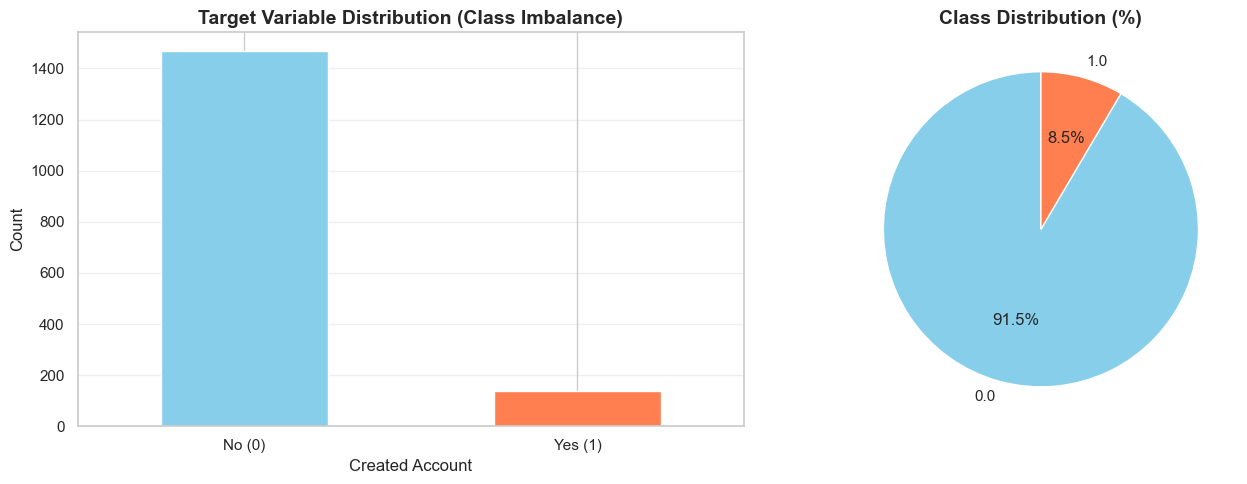

Class imbalance ratio: 10.79:1


In [11]:
# 1. TARGET VARIABLE DISTRIBUTION & CLASS IMBALANCE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
clean_df['created_account'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('Target Variable Distribution (Class Imbalance)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Created Account')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
clean_df['created_account'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                                 colors=['skyblue', 'coral'], startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig(PLOTS_DIR / '01_target_distribution.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '01_target_distribution.png'}")
plt.show()
plt.close()

print(f"Class imbalance ratio: {clean_df['created_account'].value_counts()[0] / clean_df['created_account'].value_counts()[1]:.2f}:1")


✓ Saved: ..\eda_plots\02_numeric_distributions.png


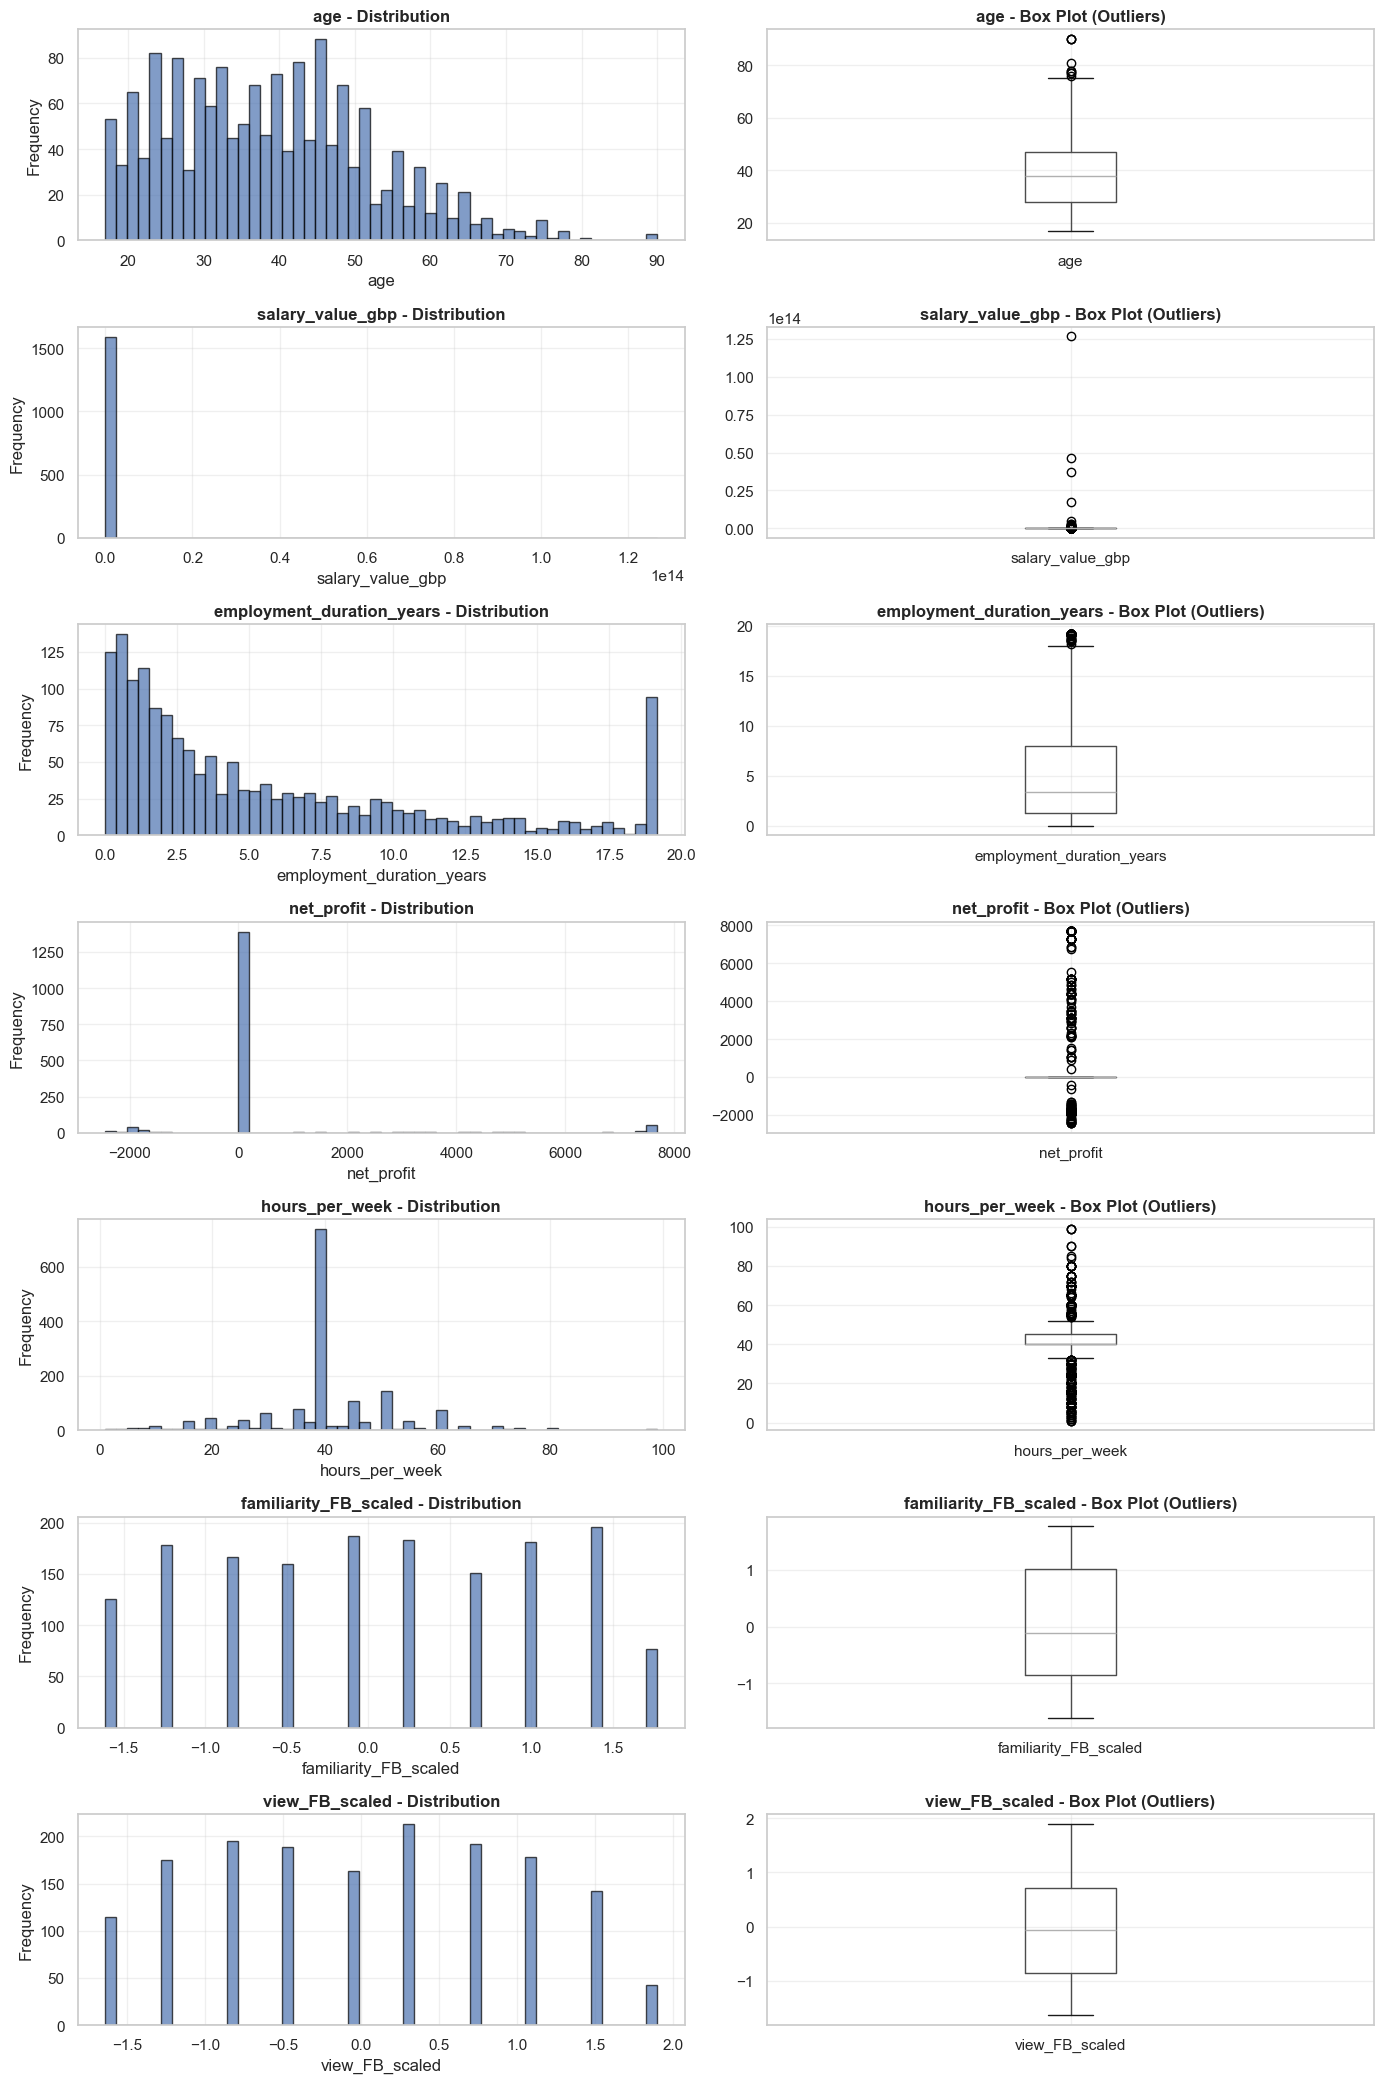

In [ ]:
# 2. NUMERIC FEATURE DISTRIBUTIONS (Histograms & Box Plots)
numeric_features = ['age', 'employment_duration_years', 
                    'net_profit', 'hours_per_week', 'familiarity_FB_scaled', 'view_FB_scaled']

# Ensure all numeric features are truly numeric
for col in numeric_features:
    if col in clean_df.columns:
        clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

fig, axes = plt.subplots(len(numeric_features), 2, figsize=(14, 3 * len(numeric_features)))

for idx, feature in enumerate(numeric_features):
    if feature in clean_df.columns:
        # Histogram
        clean_df[feature].hist(bins=50, ax=axes[idx, 0], edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f'{feature} - Distribution', fontweight='bold')
        axes[idx, 0].set_xlabel(feature)
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].grid(alpha=0.3)

        # Box plot
        clean_df.boxplot(column=feature, ax=axes[idx, 1], vert=True)
        axes[idx, 1].set_title(f'{feature} - Box Plot (Outliers)', fontweight='bold')
        axes[idx, 1].grid(alpha=0.3)
    else:
        # Optional: annotate missing features
        axes[idx, 0].text(0.5, 0.5, f'{feature} not found', ha='center', va='center')
        axes[idx, 1].text(0.5, 0.5, f'{feature} not found', ha='center', va='center')
        for ax in axes[idx]:
            ax.set_axis_off()

plt.tight_layout()
plt.savefig(PLOTS_DIR / '02_numeric_distributions.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '02_numeric_distributions.png'}")
plt.show()
plt.close()

✓ Saved: ..\eda_plots\03_feature_distributions_by_target.png


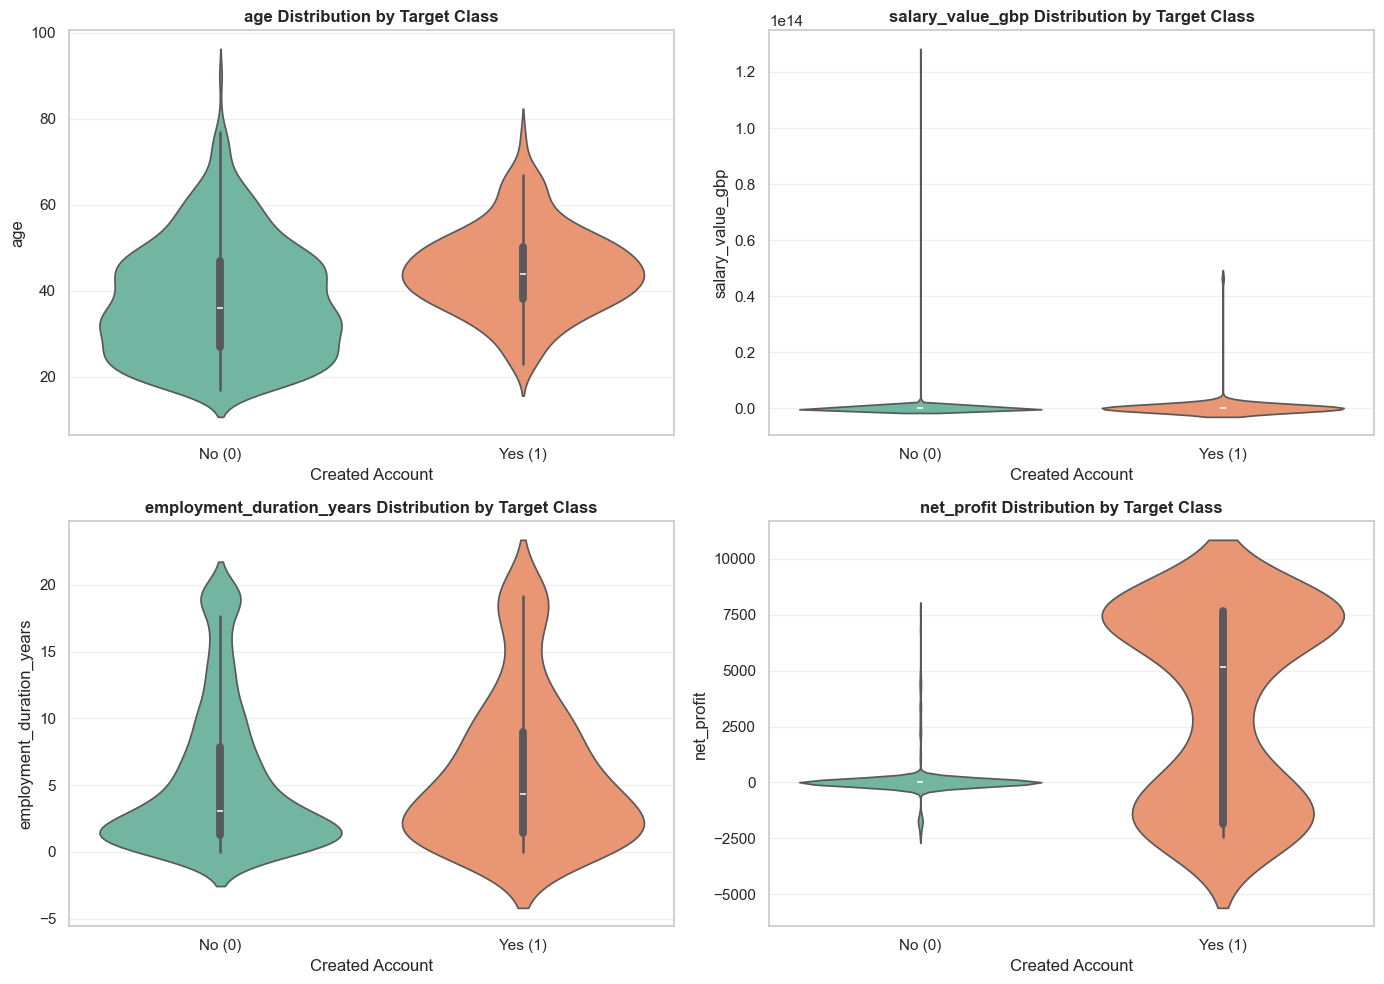

In [8]:
# 3. FEATURE DISTRIBUTIONS BY TARGET CLASS (Violin/Box Plots)
key_numeric = ['age', 'salary_value_gbp', 'employment_duration_years', 'net_profit']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_numeric):
    if feature in clean_df.columns:
        # Violin plot
        sns.violinplot(data=clean_df, x='created_account', y=feature, ax=axes[idx], palette='Set2')
        axes[idx].set_title(f'{feature} Distribution by Target Class', fontweight='bold')
        axes[idx].set_xlabel('Created Account')
        axes[idx].set_xticklabels(['No (0)', 'Yes (1)'])
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '03_feature_distributions_by_target.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '03_feature_distributions_by_target.png'}")
plt.show()
plt.close()


✓ Saved: ..\eda_plots\04_correlation_heatmap.png


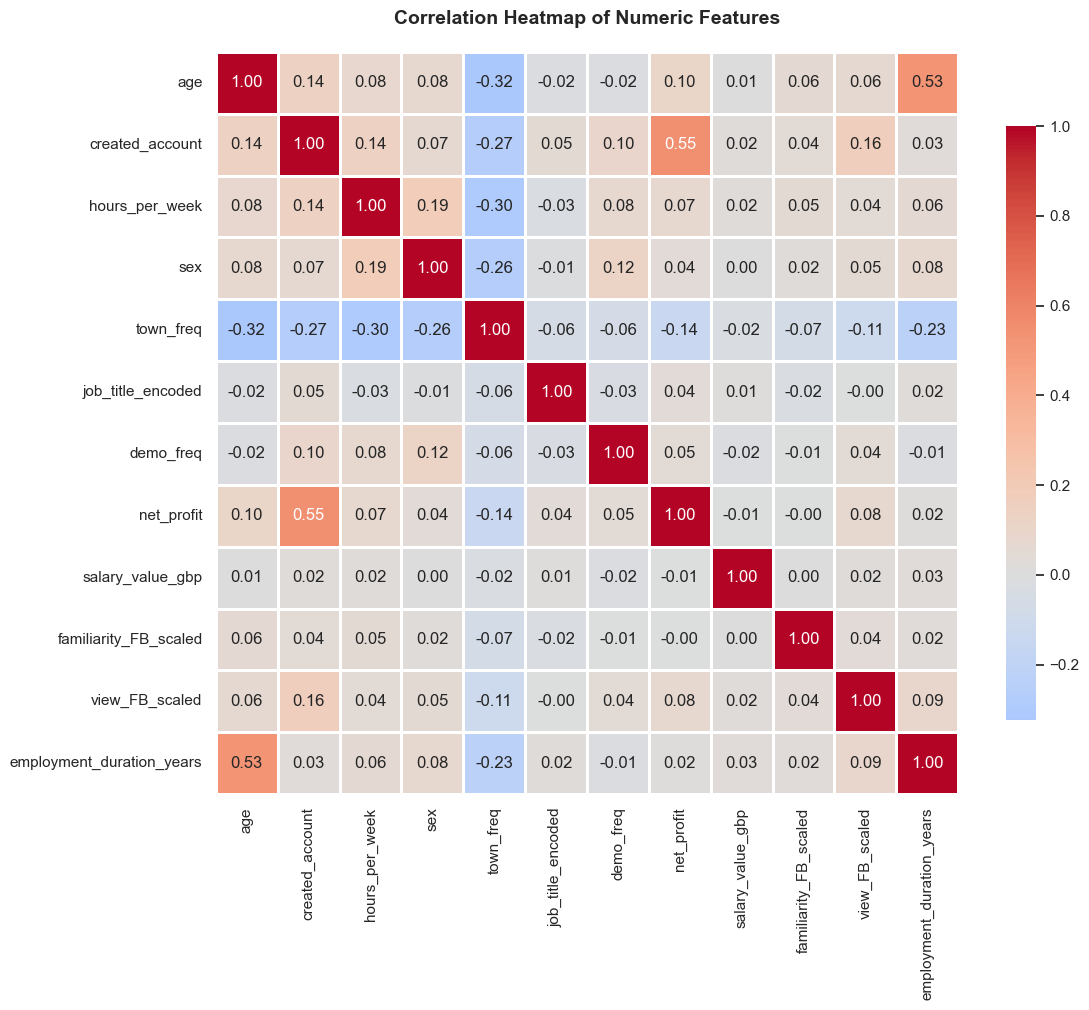

In [14]:
# 4. CORRELATION HEATMAP (for numeric features)
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target and encoded columns for cleaner view
corr_cols = [col for col in numeric_cols if not any(x in col for x in ['edu_', 'age_', 'marital_', 'religion_', 'relationship_', 'workclass_', 'race_', 'native_country_', 'edu_num_'])]

corr_matrix = clean_df[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numeric Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(PLOTS_DIR / '04_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '04_correlation_heatmap.png'}")
plt.show()
plt.close()


✓ Saved: ..\eda_plots\05_categorical_distributions_by_target.png


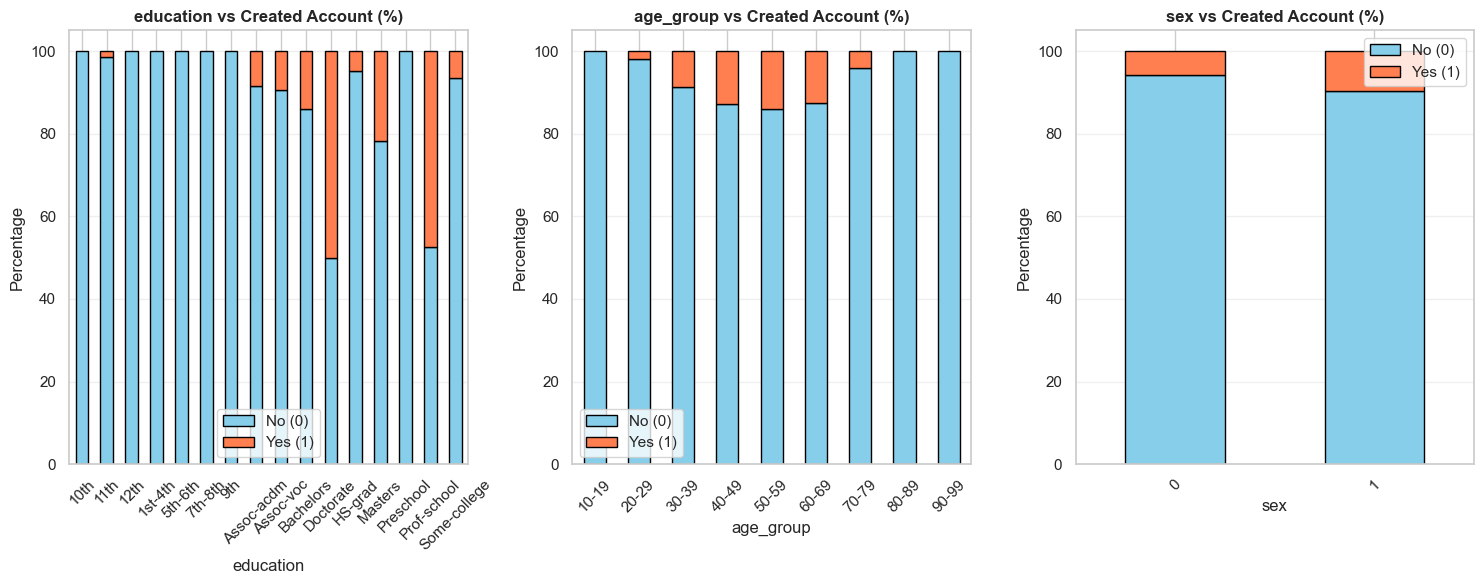

In [15]:
# 5. CATEGORICAL VARIABLE DISTRIBUTIONS BY TARGET (Stacked Bar Charts)
# Reconstruct categorical columns for visualization
if 'education' not in clean_df.columns:
    edu_cols = [col for col in clean_df.columns if col.startswith('edu_')]
    if edu_cols:
        clean_df['education'] = clean_df[edu_cols].idxmax(axis=1).str.replace('edu_', '')

if 'age_group' not in clean_df.columns:
    age_cols = [col for col in clean_df.columns if col.startswith('age_')]
    if age_cols:
        clean_df['age_group'] = clean_df[age_cols].idxmax(axis=1).str.replace('age_', '')

categorical_vars = ['education', 'age_group', 'sex']
categorical_vars = [var for var in categorical_vars if var in clean_df.columns]

fig, axes = plt.subplots(1, len(categorical_vars), figsize=(5*len(categorical_vars), 6))

for idx, var in enumerate(categorical_vars):
    if var in clean_df.columns:
        crosstab = pd.crosstab(clean_df[var], clean_df['created_account'], normalize='index') * 100
        crosstab.plot(kind='bar', stacked=True, ax=axes[idx], color=['skyblue', 'coral'], edgecolor='black')
        axes[idx].set_title(f'{var} vs Created Account (%)', fontweight='bold')
        axes[idx].set_xlabel(var)
        axes[idx].set_ylabel('Percentage')
        axes[idx].legend(['No (0)', 'Yes (1)'])
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '05_categorical_distributions_by_target.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '05_categorical_distributions_by_target.png'}")
plt.show()
plt.close()


✓ Saved: ..\eda_plots\06_scatter_plots.png


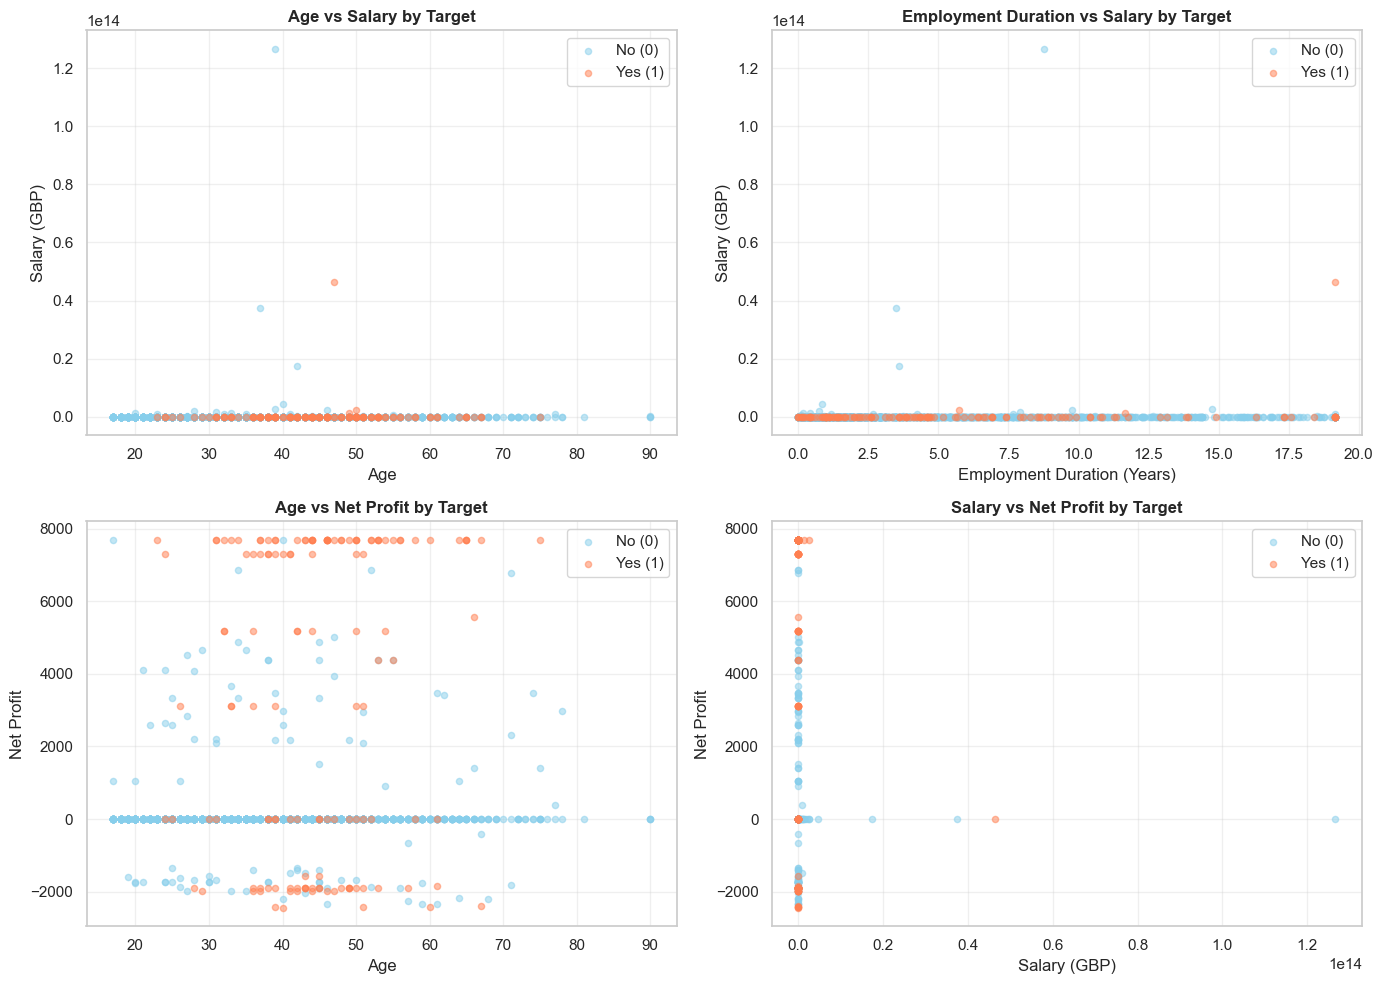

In [16]:
# 6. SCATTER PLOTS: Key Feature Relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age vs Salary by Target
if 'age' in clean_df.columns and 'salary_value_gbp' in clean_df.columns:
    scatter1 = axes[0, 0].scatter(clean_df[clean_df['created_account']==0]['age'], 
                                  clean_df[clean_df['created_account']==0]['salary_value_gbp'],
                                  alpha=0.5, label='No (0)', color='skyblue', s=20)
    scatter2 = axes[0, 0].scatter(clean_df[clean_df['created_account']==1]['age'], 
                                  clean_df[clean_df['created_account']==1]['salary_value_gbp'],
                                  alpha=0.5, label='Yes (1)', color='coral', s=20)
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Salary (GBP)')
    axes[0, 0].set_title('Age vs Salary by Target', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

# Employment Duration vs Salary by Target
if 'employment_duration_years' in clean_df.columns and 'salary_value_gbp' in clean_df.columns:
    axes[0, 1].scatter(clean_df[clean_df['created_account']==0]['employment_duration_years'], 
                       clean_df[clean_df['created_account']==0]['salary_value_gbp'],
                       alpha=0.5, label='No (0)', color='skyblue', s=20)
    axes[0, 1].scatter(clean_df[clean_df['created_account']==1]['employment_duration_years'], 
                       clean_df[clean_df['created_account']==1]['salary_value_gbp'],
                       alpha=0.5, label='Yes (1)', color='coral', s=20)
    axes[0, 1].set_xlabel('Employment Duration (Years)')
    axes[0, 1].set_ylabel('Salary (GBP)')
    axes[0, 1].set_title('Employment Duration vs Salary by Target', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

# Age vs Net Profit by Target
if 'age' in clean_df.columns and 'net_profit' in clean_df.columns:
    axes[1, 0].scatter(clean_df[clean_df['created_account']==0]['age'], 
                       clean_df[clean_df['created_account']==0]['net_profit'],
                       alpha=0.5, label='No (0)', color='skyblue', s=20)
    axes[1, 0].scatter(clean_df[clean_df['created_account']==1]['age'], 
                       clean_df[clean_df['created_account']==1]['net_profit'],
                       alpha=0.5, label='Yes (1)', color='coral', s=20)
    axes[1, 0].set_xlabel('Age')
    axes[1, 0].set_ylabel('Net Profit')
    axes[1, 0].set_title('Age vs Net Profit by Target', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

# Salary vs Net Profit by Target
if 'salary_value_gbp' in clean_df.columns and 'net_profit' in clean_df.columns:
    axes[1, 1].scatter(clean_df[clean_df['created_account']==0]['salary_value_gbp'], 
                       clean_df[clean_df['created_account']==0]['net_profit'],
                       alpha=0.5, label='No (0)', color='skyblue', s=20)
    axes[1, 1].scatter(clean_df[clean_df['created_account']==1]['salary_value_gbp'], 
                       clean_df[clean_df['created_account']==1]['net_profit'],
                       alpha=0.5, label='Yes (1)', color='coral', s=20)
    axes[1, 1].set_xlabel('Salary (GBP)')
    axes[1, 1].set_ylabel('Net Profit')
    axes[1, 1].set_title('Salary vs Net Profit by Target', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '06_scatter_plots.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '06_scatter_plots.png'}")
plt.show()
plt.close()


✓ Saved: ..\eda_plots\07_missing_values.png


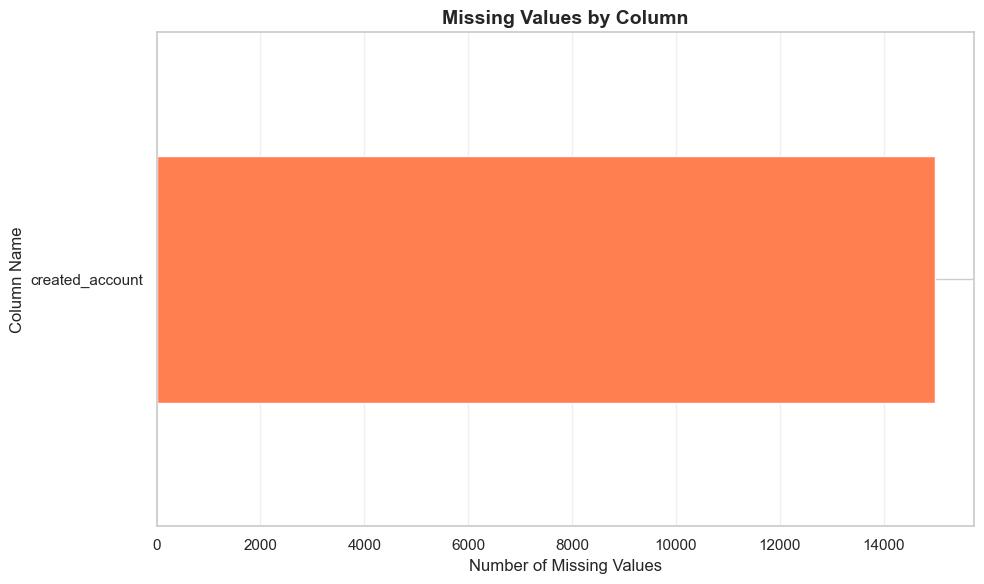

Missing values percentage:
created_account    90.33
dtype: float64


In [17]:
# 7. MISSING VALUES VISUALIZATION
missing_data = merged_df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    plt.figure(figsize=(10, 6))
    missing_data.plot(kind='barh', color='coral')
    plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Column Name')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / '07_missing_values.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {PLOTS_DIR / '07_missing_values.png'}")
    plt.show()
    plt.close()
    
    # Percentage missing
    missing_pct = (missing_data / len(merged_df) * 100).round(2)
    print("Missing values percentage:")
    print(missing_pct)
else:
    print("No missing values found in merged dataset")


Outlier Summary (IQR Method):


,Feature,Outliers Count,Outlier %,Lower Bound,Upper Bound
0,age,9,0.56,-0.500,75.500
1,salary_value_gbp,208,12.97,-6632.550,62421.930
2,employment_duration_years,103,6.42,-8.875,18.125
3,net_profit,215,13.40,0.000,0.000


✓ Saved: ..\eda_plots\08_outlier_detection.png


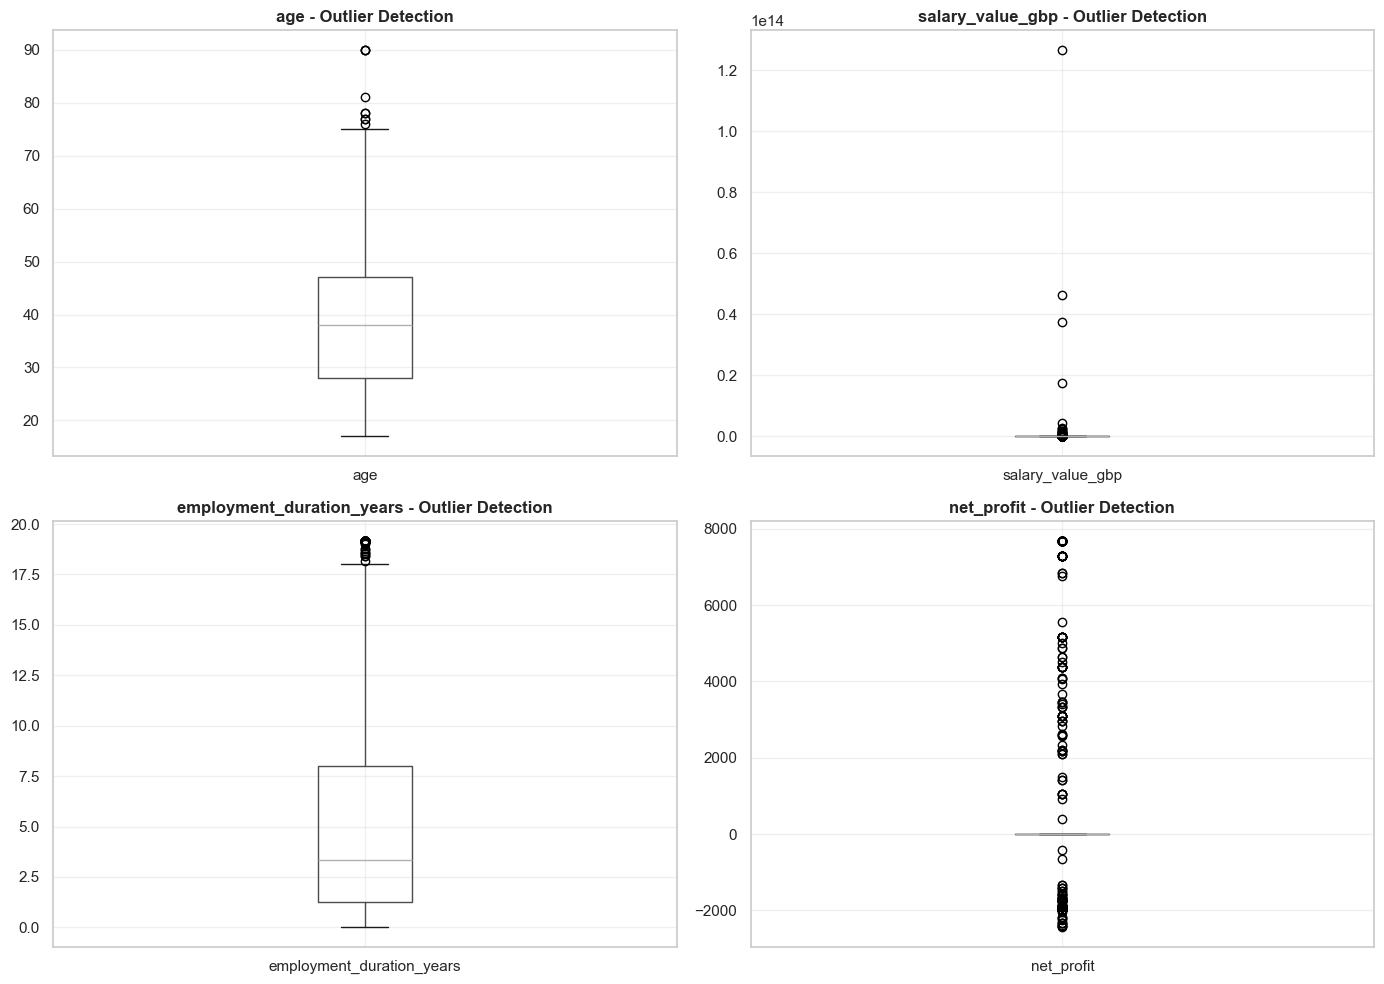

In [19]:
# 8. OUTLIER DETECTION (IQR Method) for Key Numeric Features
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

key_features = ['age', 'salary_value_gbp', 'employment_duration_years', 'net_profit']
key_features = [f for f in key_features if f in clean_df.columns]

outlier_summary = []
for feature in key_features:
    outliers, lower, upper = detect_outliers_iqr(clean_df, feature)
    outlier_summary.append({
        'Feature': feature,
        'Outliers Count': len(outliers),
        'Outlier %': round(len(outliers) / len(clean_df) * 100, 2),
        'Lower Bound': lower,
        'Upper Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary)
print("Outlier Summary (IQR Method):")
display(outlier_df)

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    clean_df.boxplot(column=feature, ax=axes[idx], vert=True)
    axes[idx].set_title(f'{feature} - Outlier Detection', fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '08_outlier_detection.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '08_outlier_detection.png'}")
plt.show()
plt.close()


In [20]:
# 9. STATISTICAL SUMMARY BY TARGET CLASS
numeric_cols = ['age', 'salary_value_gbp', 'employment_duration_years', 'net_profit', 'hours_per_week']
numeric_cols = [col for col in numeric_cols if col in clean_df.columns]

summary_by_target = clean_df.groupby('created_account')[numeric_cols].agg(['mean', 'median', 'std', 'min', 'max'])
print("Statistical Summary by Target Class:")
display(summary_by_target)


Statistical Summary by Target Class:


age                           salary_value_gbp                                               employment_duration_years         \
                      mean median        std min max             mean   median           std      min           max                      mean median   
created_account                                                                                                                                        
0.0              38.051090   36.0  13.531129  17  90     1.399343e+11  23402.0  3.487580e+12   936.96  1.266339e+14                  5.418713   3.08   
1.0              44.823529   44.0   9.834092  23  75     3.741820e+11  35878.5  4.005772e+12  8328.64  4.631446e+13                  6.015515   4.33   

                                        net_profit                                      hours_per_week                            
                      std  min    max         mean  median          std     min     max           mean median        std min max  
created_account                                                                                                                   
0.0              5.500867  0.0  19.17    67.669619     0.0   783.465605 -2339.0  7688.0      39.960490   40.0  12.111831   1  99  
1.0              5.598846  0.0  19.17  3446.367647  5178.0  4224.723501 -2444.0  7688.0      46.294118   45.0  12.466321   1  99

✓ Saved: ..\eda_plots\10_pair_plot.png


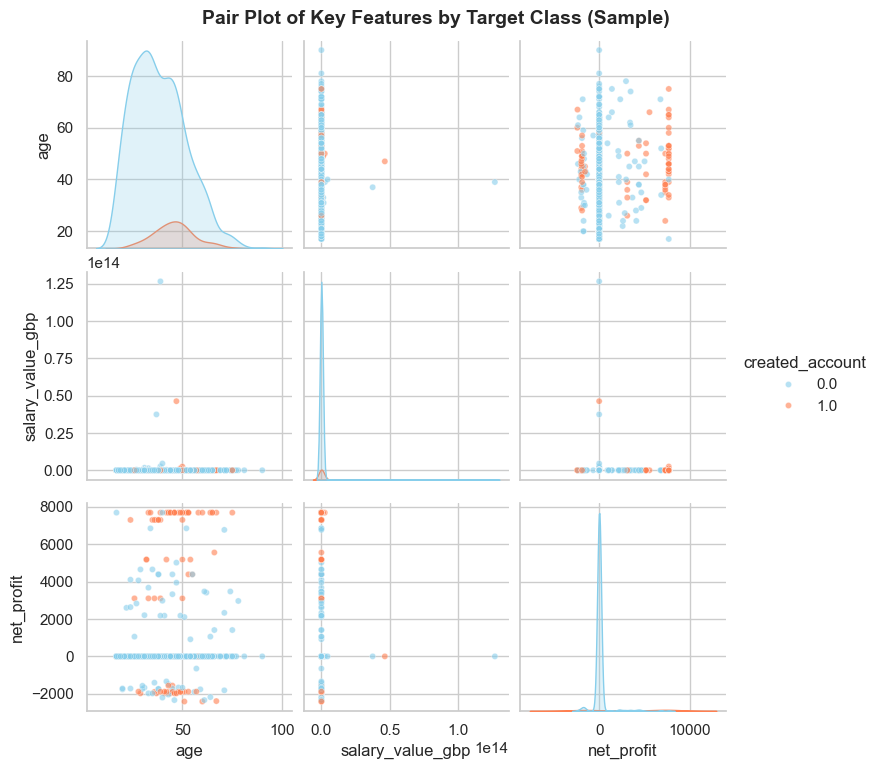

In [21]:
# 10. PAIR PLOT for Key Numeric Features (Sample)
# Sample data for faster plotting
sample_size = min(1000, len(clean_df))
sample_df = clean_df.sample(n=sample_size, random_state=42)

key_features_pair = ['age', 'salary_value_gbp', 'net_profit', 'created_account']
key_features_pair = [f for f in key_features_pair if f in sample_df.columns]

if len(key_features_pair) >= 3:
    pair_plot_df = sample_df[key_features_pair].copy()
    pair_plot_df['created_account'] = pair_plot_df['created_account'].astype(str)
    
    g = sns.pairplot(pair_plot_df, hue='created_account', diag_kind='kde', 
                     palette=['skyblue', 'coral'], plot_kws={'alpha': 0.6, 's': 20})
    g.fig.suptitle('Pair Plot of Key Features by Target Class (Sample)', y=1.02, fontsize=14, fontweight='bold')
    plt.savefig(PLOTS_DIR / '10_pair_plot.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {PLOTS_DIR / '10_pair_plot.png'}")
    plt.show()
    plt.close()


✓ Saved: ..\eda_plots\11_cdf_plots.png


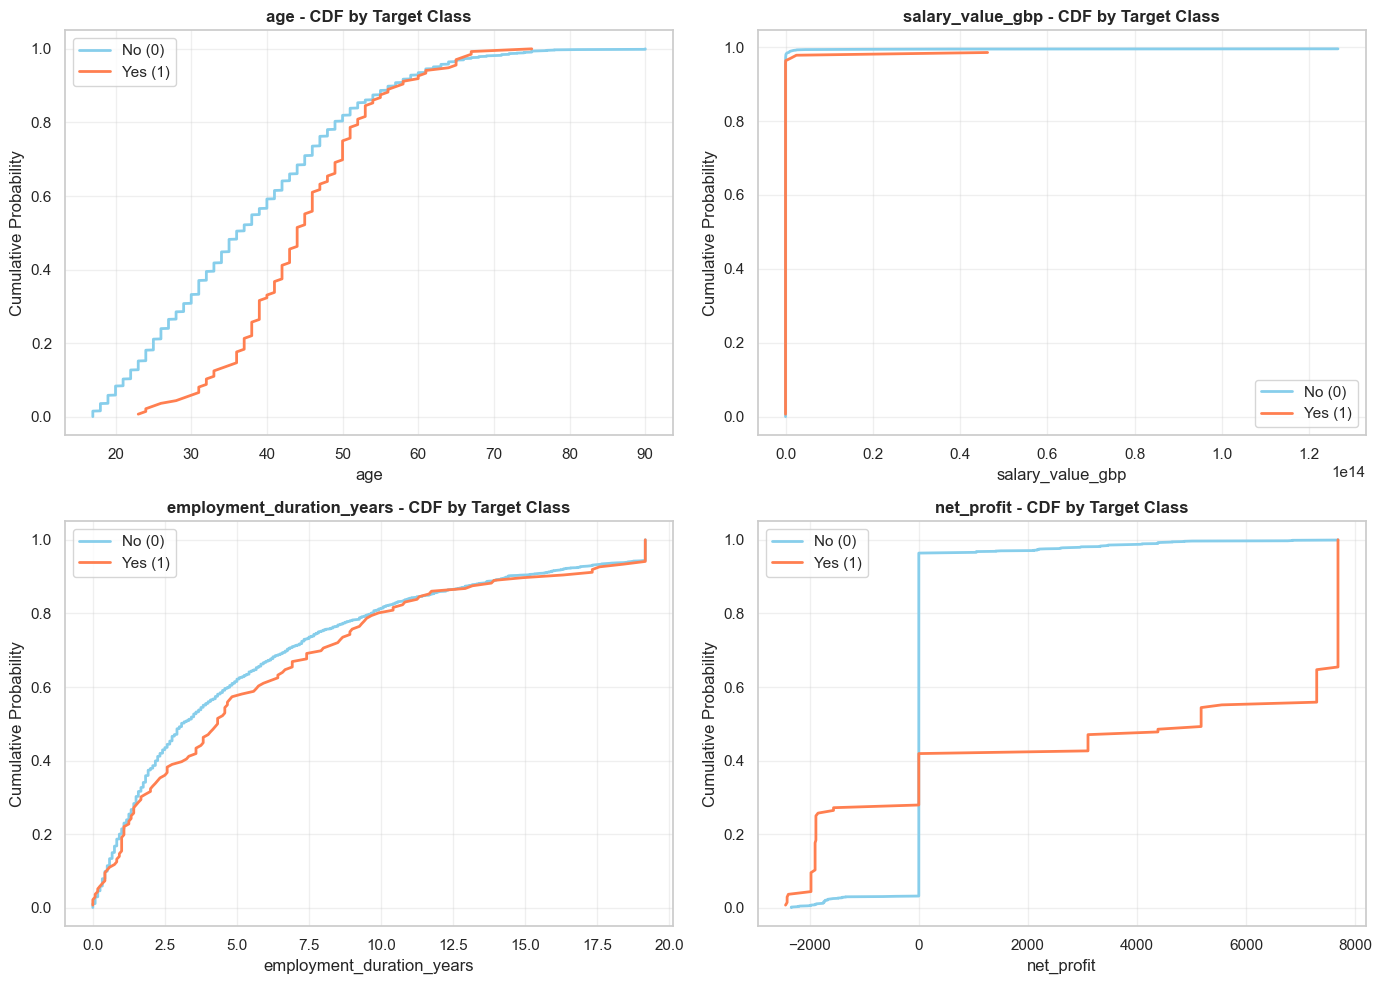

In [22]:
# 11. CUMULATIVE DISTRIBUTION FUNCTION (CDF) for Key Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

key_features_cdf = ['age', 'salary_value_gbp', 'employment_duration_years', 'net_profit']
key_features_cdf = [f for f in key_features_cdf if f in clean_df.columns]

for idx, feature in enumerate(key_features_cdf):
    # CDF for class 0
    data_0 = clean_df[clean_df['created_account']==0][feature].sort_values()
    y_0 = np.arange(1, len(data_0)+1) / len(data_0)
    axes[idx].plot(data_0, y_0, label='No (0)', linewidth=2, color='skyblue')
    
    # CDF for class 1
    data_1 = clean_df[clean_df['created_account']==1][feature].sort_values()
    y_1 = np.arange(1, len(data_1)+1) / len(data_1)
    axes[idx].plot(data_1, y_1, label='Yes (1)', linewidth=2, color='coral')
    
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Cumulative Probability')
    axes[idx].set_title(f'{feature} - CDF by Target Class', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '11_cdf_plots.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '11_cdf_plots.png'}")
plt.show()
plt.close()


✓ Saved: ..\eda_plots\12_feature_importance.png


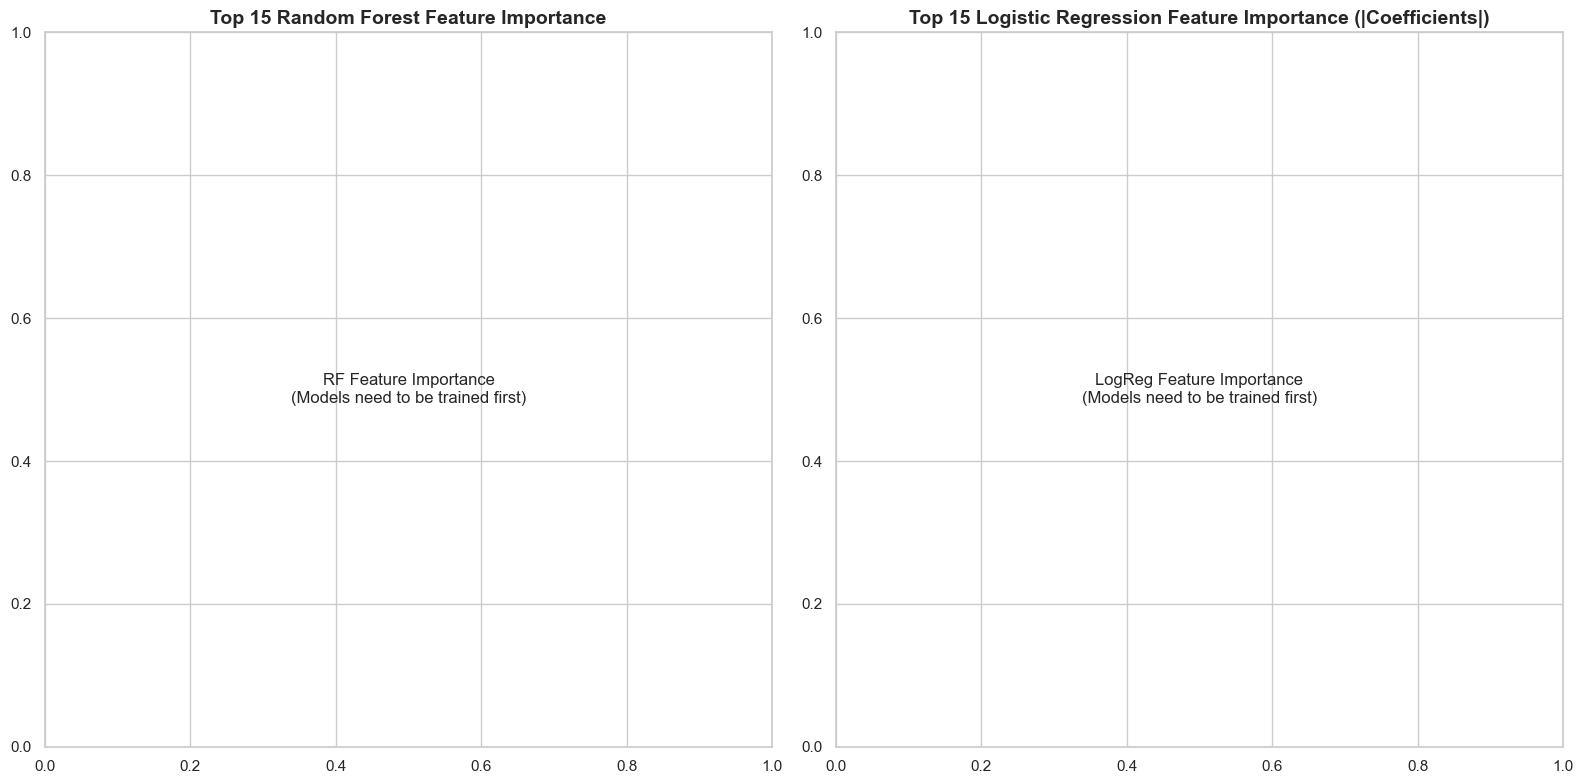

In [23]:
# 12. FEATURE IMPORTANCE COMPARISON (Top Features Side-by-Side)
# Note: This requires trained models. If models are not available, this cell will show empty plots.
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest Feature Importance (Top 15)
if 'rf_feat_imp' in locals():
    rf_feat_imp.head(15).plot(kind='barh', ax=axes[0], color='steelblue')
    axes[0].set_title('Top 15 Random Forest Feature Importance', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Importance Score')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'RF Feature Importance\n(Models need to be trained first)', 
                 ha='center', va='center', fontsize=12)
    axes[0].set_title('Top 15 Random Forest Feature Importance', fontsize=14, fontweight='bold')

# Logistic Regression Coefficients (Top 15)
if 'logreg_feat_imp' in locals():
    logreg_feat_imp.head(15).plot(kind='barh', ax=axes[1], color='coral')
    axes[1].set_title('Top 15 Logistic Regression Feature Importance (|Coefficients|)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Coefficient (Absolute Value)')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'LogReg Feature Importance\n(Models need to be trained first)', 
                 ha='center', va='center', fontsize=12)
    axes[1].set_title('Top 15 Logistic Regression Feature Importance (|Coefficients|)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / '12_feature_importance.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {PLOTS_DIR / '12_feature_importance.png'}")
plt.show()
plt.close()


In [1]:
# 13. DISTRIBUTION OF PREDICTION SCORES (for target_df)
# Note: This requires predictions to be made. If scores are not available, this cell will show a message.
if 'target_df' in locals() and 'score_rf' in target_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of RF scores
    target_df['score_rf'].hist(bins=50, ax=axes[0], edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].axvline(x=0.4, color='red', linestyle='--', linewidth=2, label='Threshold (0.4)')
    axes[0].set_title('Distribution of RF Prediction Scores', fontweight='bold')
    axes[0].set_xlabel('RF Score')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Histogram of LogReg scores
    if 'score_logreg' in target_df.columns:
        target_df['score_logreg'].hist(bins=50, ax=axes[1], edgecolor='black', alpha=0.7, color='coral')
        axes[1].axvline(x=0.4, color='red', linestyle='--', linewidth=2, label='Threshold (0.4)')
        axes[1].set_title('Distribution of LogReg Prediction Scores', fontweight='bold')
        axes[1].set_xlabel('LogReg Score')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / '13_prediction_scores.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {PLOTS_DIR / '13_prediction_scores.png'}")
    plt.show()
    plt.close()
else:
    print("Prediction scores not available. Models need to be trained and predictions made first.")


Prediction scores not available. Models need to be trained and predictions made first.


✓ Saved: ..\eda_plots\14_age_by_education.png


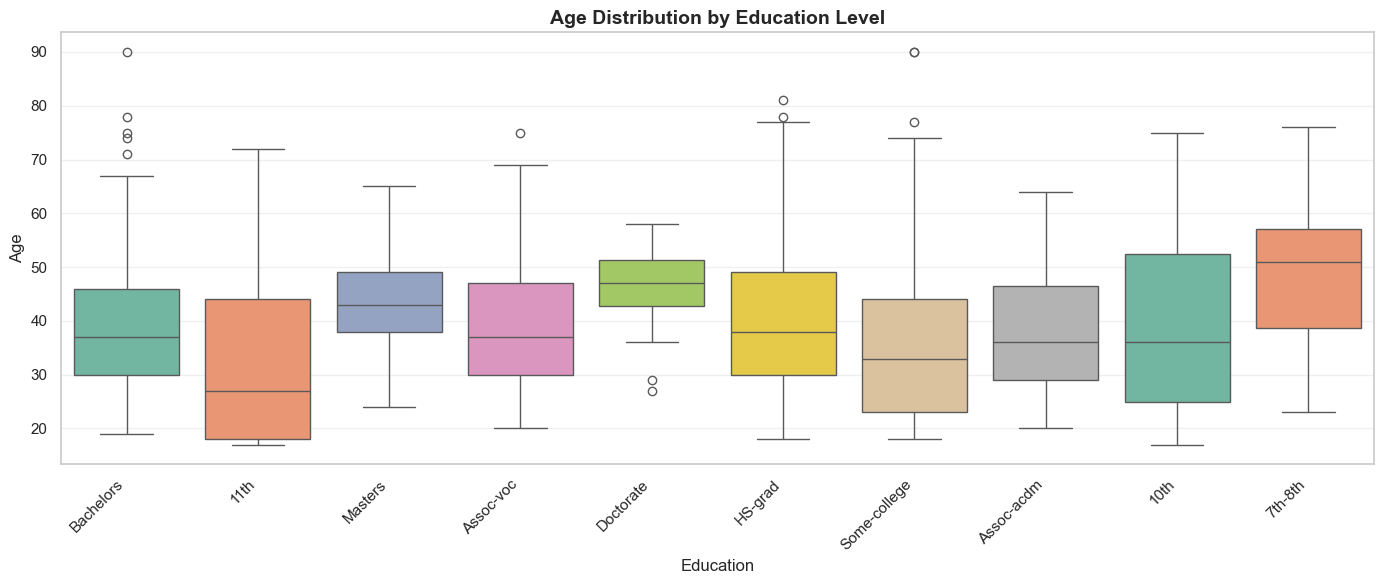

In [25]:
# 14. AGE DISTRIBUTION BY EDUCATION LEVEL
if 'education' in clean_df.columns and 'age' in clean_df.columns:
    plt.figure(figsize=(14, 6))
    
    # Box plot
    education_order = clean_df['education'].value_counts().head(10).index
    sns.boxplot(data=clean_df[clean_df['education'].isin(education_order)], 
                x='education', y='age', palette='Set2')
    plt.title('Age Distribution by Education Level', fontsize=14, fontweight='bold')
    plt.xlabel('Education')
    plt.ylabel('Age')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / '14_age_by_education.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {PLOTS_DIR / '14_age_by_education.png'}")
    plt.show()
    plt.close()


✓ Saved: ..\eda_plots\15_salary_distribution.png


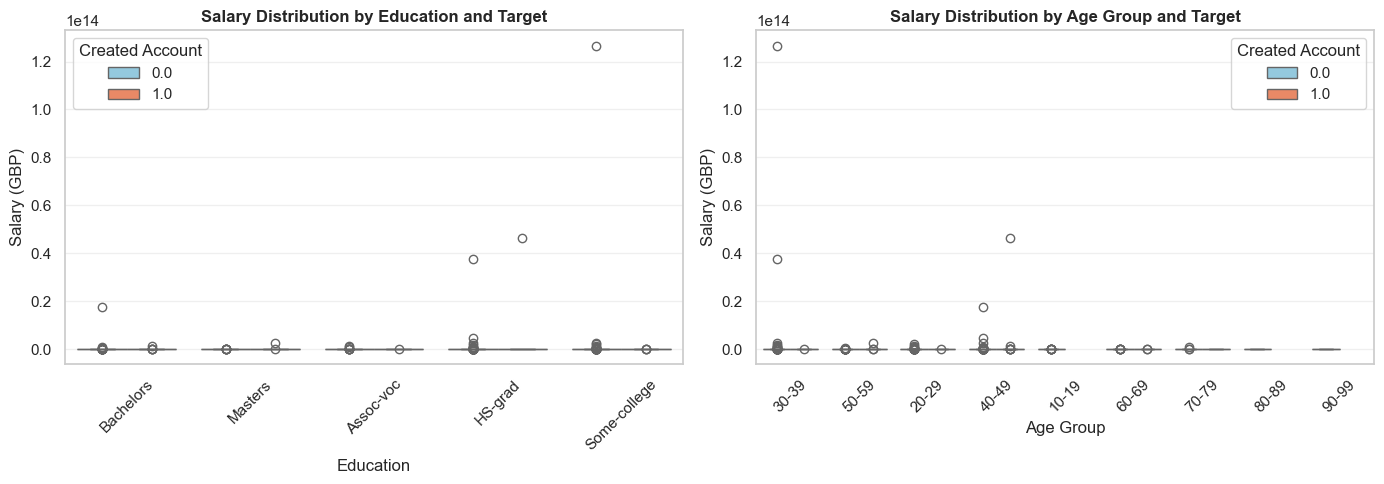

In [26]:
# 15. SALARY DISTRIBUTION BY TARGET AND KEY CATEGORICAL VARIABLES
if 'salary_value_gbp' in clean_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Salary by Education (if available)
    if 'education' in clean_df.columns:
        top_edu = clean_df['education'].value_counts().head(5).index
        sns.boxplot(data=clean_df[clean_df['education'].isin(top_edu)], 
                    x='education', y='salary_value_gbp', hue='created_account', 
                    palette=['skyblue', 'coral'], ax=axes[0])
        axes[0].set_title('Salary Distribution by Education and Target', fontweight='bold')
        axes[0].set_xlabel('Education')
        axes[0].set_ylabel('Salary (GBP)')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].legend(title='Created Account')
        axes[0].grid(axis='y', alpha=0.3)
    
    # Salary by Age Group (if available)
    if 'age_group' in clean_df.columns:
        sns.boxplot(data=clean_df, x='age_group', y='salary_value_gbp', 
                    hue='created_account', palette=['skyblue', 'coral'], ax=axes[1])
        axes[1].set_title('Salary Distribution by Age Group and Target', fontweight='bold')
        axes[1].set_xlabel('Age Group')
        axes[1].set_ylabel('Salary (GBP)')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend(title='Created Account')
        axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / '15_salary_distribution.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {PLOTS_DIR / '15_salary_distribution.png'}")
    plt.show()
    plt.close()
